## 1. Birth Rate vs. Socio-economic Drivers

### Scatter + Trendline

Plot the relationship between Birth Rate (on the y-axis) and each of the following socio-economic indicators (on the x-axis) separately:

* GDP per capita
* Internet Users (%)
* CO₂ per capita

### Faceted Scatter Matrix

 This matrix will display the pairwise relationships between Birth Rate and all the chosen predictor variables (GDP per capita, Internet Users %, CO₂ per capita). This approach provides an instant overview of how these variables co-move with birth rate and with each other.

### Lagged Analysis

To explore potential delayed effects of economic factors on birth rates, compute lagged versions of the socio-economic indicators.

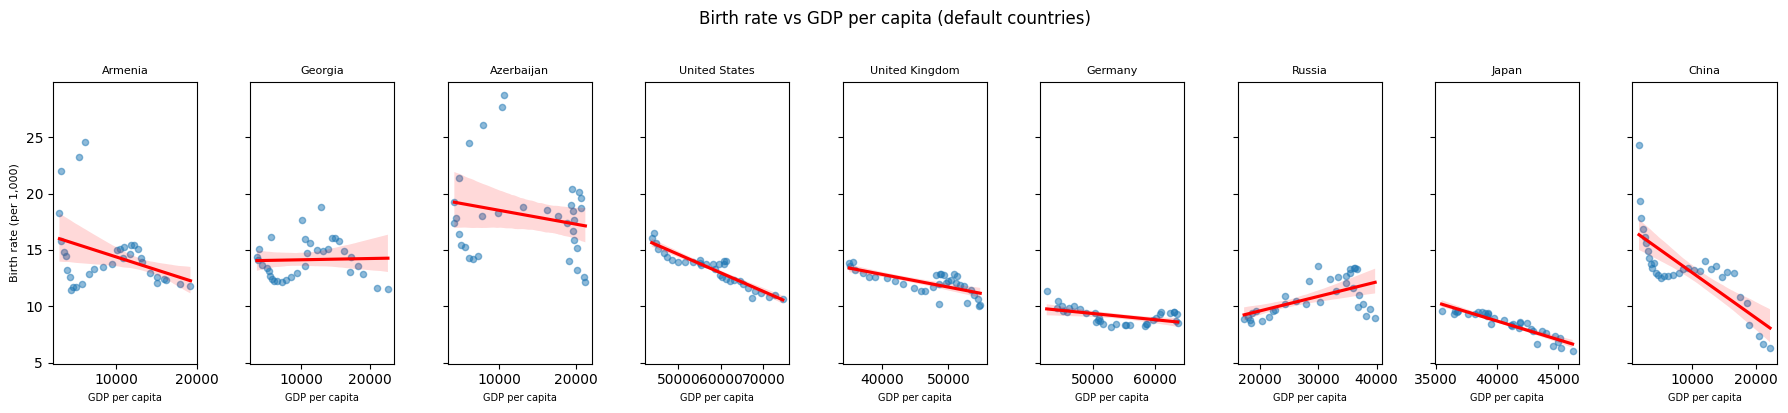

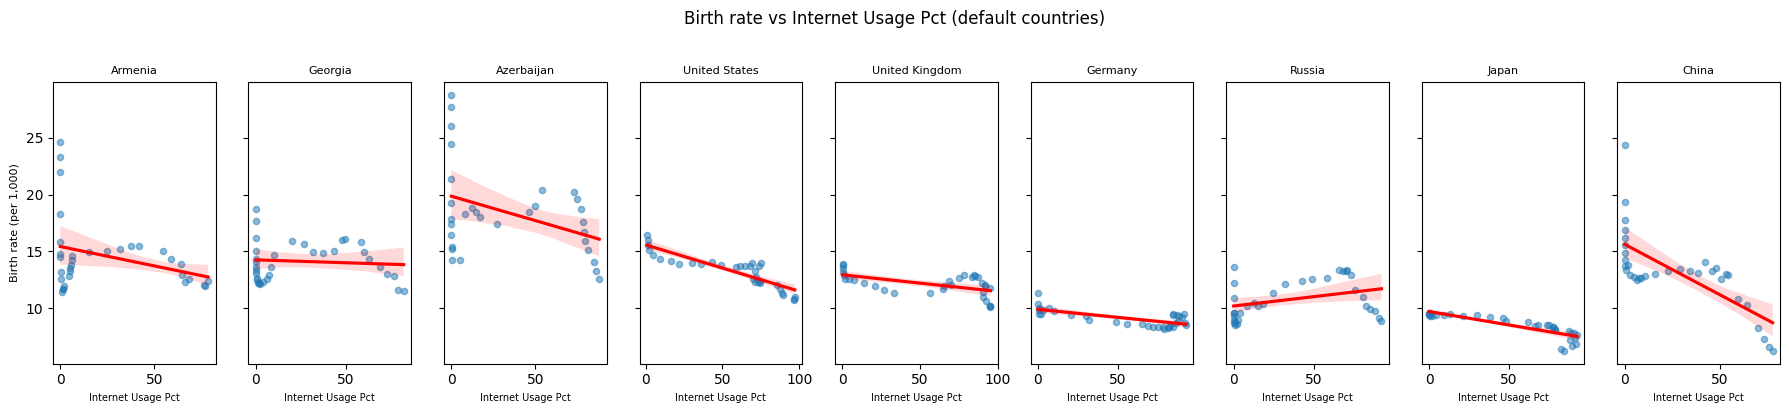

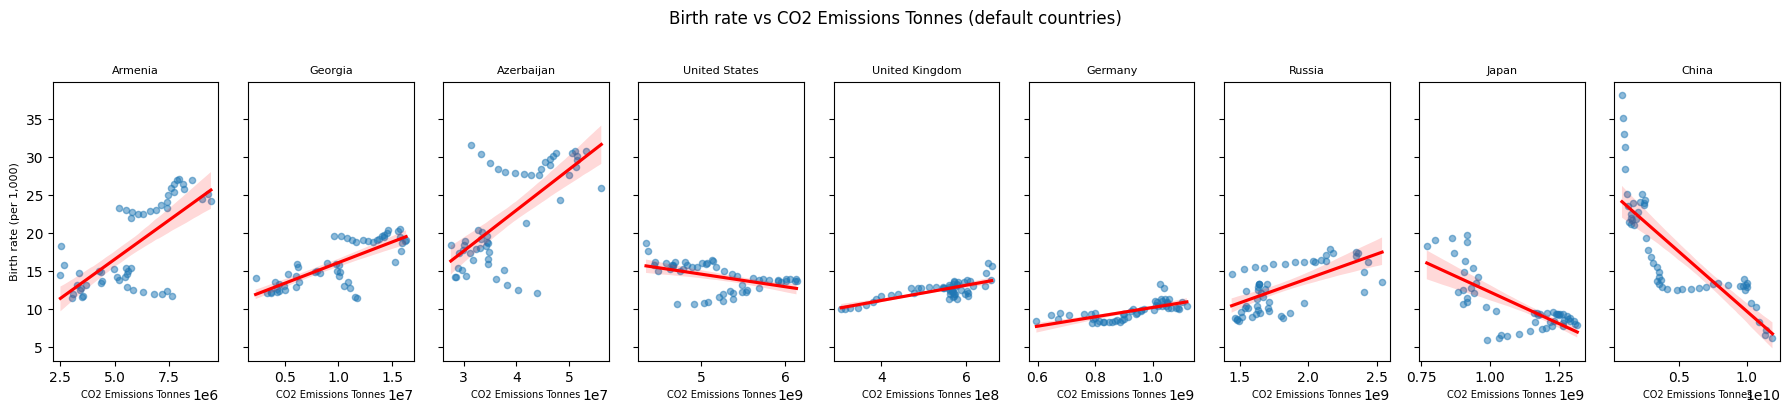

In [9]:
from dash import Dash, dcc, html, Input, Output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import importlib
import constants
import plotly.express as px
import plotly.graph_objects as go

importlib.reload(constants)

default_countries = constants.default_countries

df = pd.read_csv("../data/generated/filtered_dataset.csv")

predictors = ["GDP_per_capita", "Internet_Usage_Pct", "CO2_Emissions_Tonnes"]


for col in predictors:
    # filter to our 10
    df_sub = df[df['Entity'].isin(default_countries)]

    # set up a 1×10 grid of axes
    fig, axes = plt.subplots(
        nrows=1, ncols=len(default_countries),
        figsize=(len(default_countries)*2, 4),
        sharey=True
    )

    # plot each country in its own subplot
    for ax, country in zip(axes, default_countries):
        d = df_sub[df_sub['Entity'] == country]
        sns.regplot(
            x=col,
            y="Birth rate",
            data=d,
            ax=ax,
            scatter_kws={"alpha": 0.5, "s": 20},
            line_kws={"color": "red"}
        )
        ax.set_title(country, fontsize=8)
        ax.set_xlabel(col.replace("_", " "), fontsize=7)
        if ax is axes[0]:
            ax.set_ylabel("Birth rate (per 1,000)", fontsize=8)
        else:
            ax.set_ylabel("")

    plt.suptitle(f"Birth rate vs {col.replace('_',' ')} (default countries)", y=1.02)
    plt.tight_layout()
    plt.show()


There are 3 plots above, which show how Birth rate is interconnected with GDP per capita chagne, Internet Usage Pct and CO2 Emissions accordingly. From the plot we see that for example in most of the countries the internet usage and birth rate show almost alike trend and the same can be deducted from the first plot of Birth Rate vs GDP per capita, where if GDP follows a negative trend then the Birth rate is also following it and the vica versa.

In [10]:
all_countries = sorted(df['Entity'].dropna().unique())

app1 = Dash(__name__)
app1.title = "Birth Rate vs Socio-economic Drivers"

app1.layout = html.Div(
    style={
        "display": "flex",
        "flexDirection": "row",
        "backgroundColor": "#ffffff",
        "color": "#000000",
        "fontFamily": "Arial, sans-serif",
        "padding": "20px",
        "height": "auto",
        "width": "calc(100% - 40px)"
    },
    children=[
        # Sidebar with checklist
        html.Div([
            html.H4("Select countries:", style={"marginBottom": "10px"}),
            dcc.Checklist(
                id='country-selector',
                options=[{"label": c, "value": c} for c in all_countries],
                value=default_countries,
                inputStyle={"marginRight": "5px"},
                labelStyle={'display': 'block', 'color': '#000'},
                style={
                    "overflowY": "auto",
                    "height": "calc(100vh - 100px)",
                    "border": "1px solid #ccc",
                    "padding": "10px",
                    "backgroundColor": "#f9f9f9"
                }
            )
        ], style={
            "width": "25%",
            "marginRight": "20px"
        }),

        # Main content: scatter‐matrix
        html.Div([
            dcc.Graph(
                id='matrix-graph',
                style={
                    "height": "100%",
                    "width": "100%"
                }
            )
        ], style={
            "width": "75%",
            "height": "calc(100vh - 100px)",
        })
    ]
)

# 5. Callback to update the scatter‐matrix when countries are (de)selected
@app1.callback(
    Output('matrix-graph', 'figure'),
    Input('country-selector', 'value')
)
def update_matrix(selected_countries):
    # If none selected, return an empty placeholder
    if not selected_countries:
        fig = go.Figure()
        fig.update_layout(
            title="No countries selected",
            xaxis={"visible": False},
            yaxis={"visible": False}
        )
        return fig

    # Filter and drop NA
    subset = df[df.Entity.isin(selected_countries)][["Entity", "Birth rate"] + predictors].dropna()

    # Build scatter‐matrix
    fig = px.scatter_matrix(
        subset,
        dimensions=predictors + ["Birth rate"],
        color="Entity",
        title=f"Birth rate vs Socio-economic Drivers ({len(selected_countries)} countries)",
        height=700,
    )

    # Tidy up fonts & hiding diagonal
    fig.update_traces(diagonal_visible=False)
    fig.update_layout(
        font=dict(size=8),
        margin=dict(l=40, r=40, t=50, b=40),
        legend_title_text="Country"
    )


    return fig

# 6. Run the app
app1.run(debug=False, port=9050)

The interactive matrix graph on top show connection between different values such as GDP_per_capita with Birth rate, CO2_Emission and etc.

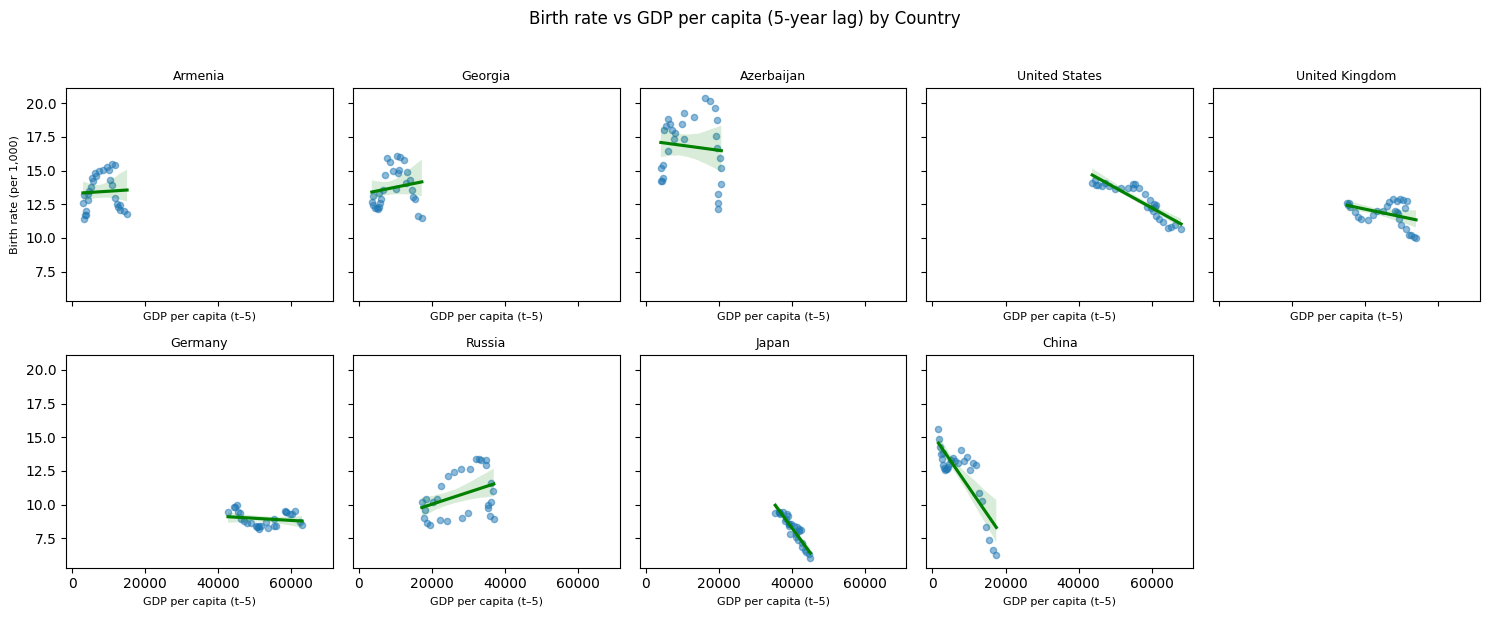

In [11]:
rows, cols = 2, 5
fig, axes = plt.subplots(
    rows, cols,
    figsize=(cols * 3, rows * 3),
    sharex=True, sharey=True
)

df = df.sort_values(["Entity", "Year"])

df["GDP_per_capita_lag5"] = df.groupby("Entity")["GDP_per_capita"].shift(5)

lag_df = df.dropna(subset=["GDP_per_capita_lag5", "Birth rate"])

# Flatten axes for easy iteration
axes = axes.flatten()

for ax, country in zip(axes, default_countries):
    df_ct = lag_df[lag_df["Entity"] == country]
    sns.regplot(
        x="GDP_per_capita_lag5",
        y="Birth rate",
        data=df_ct,
        ax=ax,
        scatter_kws={"alpha": 0.5, "s": 20},
        line_kws={"color": "green"}
    )
    ax.set_title(country, fontsize=9)
    ax.set_xlabel("GDP per capita (t–5)", fontsize=8)
    # only label the y-axis on the first subplot
    if ax is axes[0]:
        ax.set_ylabel("Birth rate (per 1,000)", fontsize=8)
    else:
        ax.set_ylabel("")

# Turn off any unused subplots (in case default_countries < rows*cols)
for ax in axes[len(default_countries):]:
    ax.axis("off")

plt.suptitle("Birth rate vs GDP per capita (5-year lag) by Country", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## 2. Death Rate & Aging “Legacy” Population
### Dual‐axis Line Chart

* Primary y: Death_Rate over time.
* Secondary y: % of population aged 65+ (“Legacy” cohort).

If they track closely, you’ve got visual proof of aging impact.

### Stacked Area of Age Groups

Show how the share of 0–14, 15–64, 65+ shifts over time.

### Population Pyramid

In [16]:
# --- 0. Combine female (_x) + male (_y) into total age groups ---
age_defs = {
    '0_4':   ('0-4 years_x',   '0-4 years_y'),
    '5_14':  ('5-14 years_x',  '5-14 years_y'),
    '15_24': ('15-24 years_x', '15-24 years_y'),
    '25_64': ('25-64 years_x', '25-64 years_y'),
    '65_plus':('65+ years_x',   '65+ years_y'),
}

# Create pop_<age> columns
for suffix, (f_col, m_col) in age_defs.items():
    df[f'pop_{suffix}'] = df[f_col] + df[m_col]

# Total population from these groups
pop_cols = [f'pop_{k}' for k in age_defs]
df['Total_pop_age'] = df[pop_cols].sum(axis=1)

# Compute %‐shares
for suffix in age_defs:
    df[f'pct_{suffix}'] = df[f'pop_{suffix}'] / df['Total_pop_age'] * 100

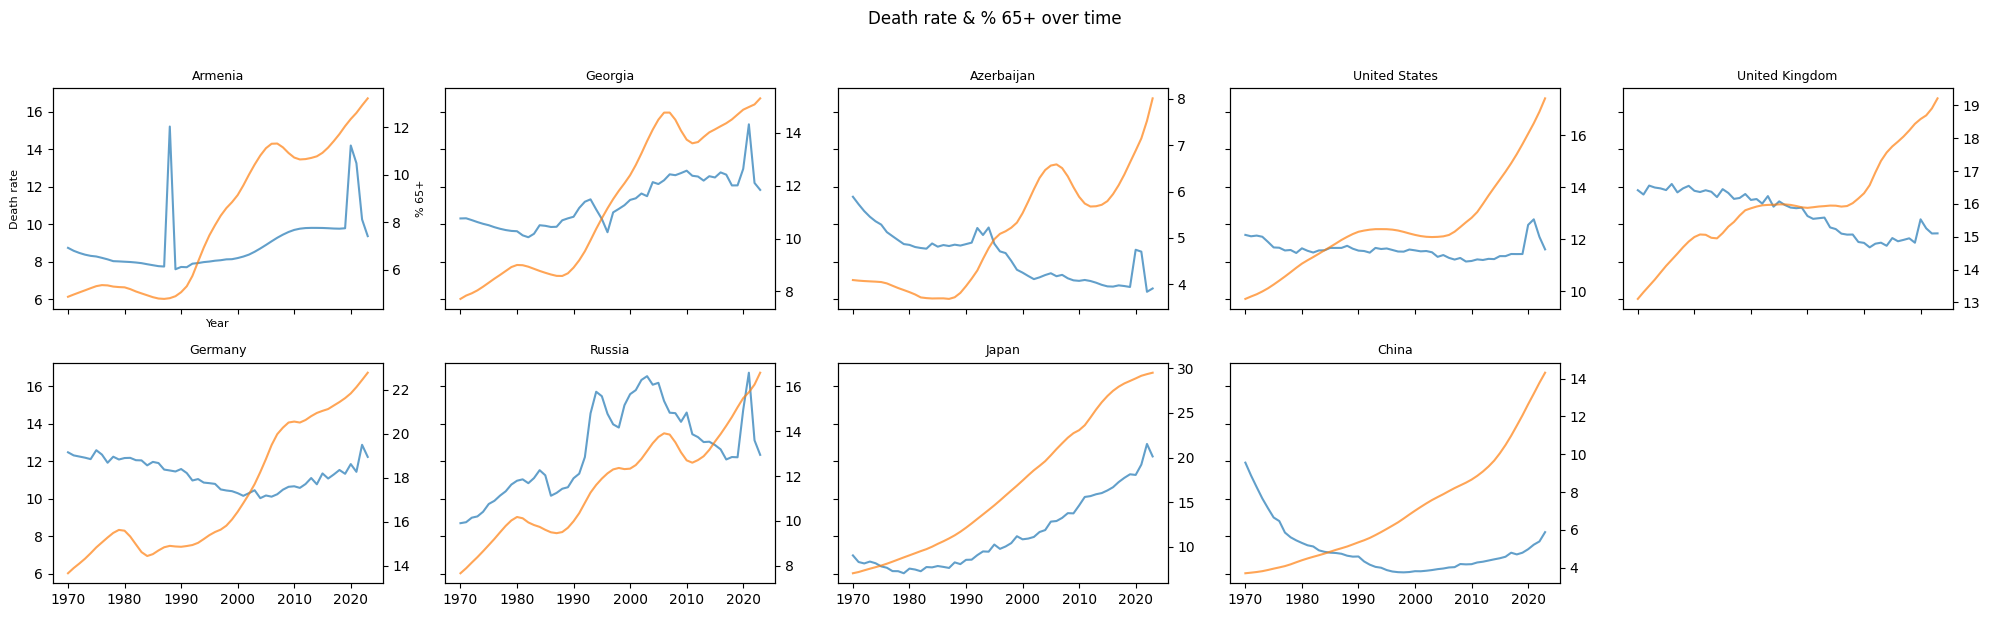

In [13]:
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, 
                         figsize=(cols*4, rows*3), 
                         sharex=True, sharey=True)
axes = axes.flatten()

for ax, country in zip(axes, default_countries):
    d = (df[df.Entity == country]
         .dropna(subset=['Death rate','pct_65_plus'])
         .sort_values('Year'))
    
    # primary y: death rate
    ax.plot(d.Year, d['Death rate'], 
            color='tab:blue', alpha=0.7, label='Death rate')
    ax.set_title(country, fontsize=9)
    
    # secondary y: % 65+
    ax2 = ax.twinx()
    ax2.plot(d.Year, d['pct_65_plus'], 
             color='tab:orange', alpha=0.7, label='% aged 65+')
    
    # only label axes on leftmost
    if ax is axes[0]:
        ax.set_xlabel('Year', fontsize=8)
        ax.set_ylabel('Death rate', fontsize=8)
        ax2.set_ylabel('% 65+', fontsize=8)
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax2.set_ylabel('')
        
# turn off unused subplots
for ax in axes[len(default_countries):]:
    ax.axis('off')

fig.suptitle('Death rate & % 65+ over time', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()


In the plot of Deat Rate and %of people aged 65 or more we can see several fluctuations which for most of the countries are a result of Pandemic like Covid-19 and in case of Armenia specifically there is a fluctutation during 1988, which was a result of Spitak earthquake.

In [ ]:
# 3. Layout
app2 = Dash(__name__)
app2.title = "Age‐Structure vs Death Rate"
app2.layout = html.Div(
    style={
        "display": "flex",
        "flexDirection": "row",
        "backgroundColor": "#ffffff",
        "color": "#000000",
        "padding": "20px",
        "height": "100vh",            # full viewport height
        "width": "100vw",
        "boxSizing": "border-box"
    },
    children=[
        # Sidebar (20%)
        html.Div([
            html.Label("Select a country:", style={"fontWeight":"bold"}),
            dcc.Dropdown(
                id='country-dd',
                options=[{"label": c, "value": c} for c in all_countries],
                value='Armenia',
                clearable=False,
                style={"width":"100%"}
            )
        ], style={
            "width": "20%",
            "minWidth": "180px",
            "marginRight": "20px"
        }),

        # Graph container (80%)
        html.Div([
            dcc.Graph(
                id='age-death-chart',
                style={
                    "width": "100%",
                    "height": "100%"    # fill that 80% height
                }
            )
        ], style={
            "width": "80%",
            "height": "100%"
        })
    ]
)

# 4. In your callback, adjust the figure margins & legend:
@app2.callback(
    Output('age-death-chart', 'figure'),
    Input('country-dd', 'value')
)
def update_age_death(country):
    d = (df[df.Entity == country]
         .dropna(subset=[f'pct_{l}' for l in age_defs] + ['Death rate'])
         .sort_values('Year'))

    fig = go.Figure()

    # stacked areas
    for label in age_defs:
        fig.add_trace(go.Scatter(
            x=d.Year,
            y=d[f'pct_{label}'],
            name=label,
            stackgroup='one',
            mode='none'
        ))

    # death rate on y2
    fig.add_trace(go.Scatter(
        x=d.Year,
        y=d['Death rate'],
        name='Death rate',
        mode='lines',
        line=dict(color='black', width=2),
        yaxis='y2'
    ))

    fig.update_layout(
        title=f'Age‐share & Death rate: {country}',
        xaxis=dict(title='Year'),
        yaxis=dict(title='Percent of total population'),
        yaxis2=dict(
            title='Death rate (per 1,000)',
            overlaying='y',
            side='right'
        ),
        # bump right margin to make room for legend
        margin=dict(l=60, r=120, t=50, b=40),
        height=None,  # lets the container dict drive the height
        legend=dict(
            x=1.02,     # just outside the plot
            y=1,
            xanchor='left',
            yanchor='top',
            bordercolor='gray',
            borderwidth=1,
            font=dict(size=10)
        ),
        font=dict(family="Arial, sans-serif")
    )

    return fig

app2.run(debug=False, port=9051)

In [15]:
rows = []
for _, r in df.iterrows():
    for label, (fx, fy) in age_defs.items():
        # skip if both male+female are missing
        if pd.isna(r[fx]) and pd.isna(r[fy]):
            continue
        rows.append({
            'Entity': r['Entity'],
            'Year':    r['Year'],
            'AgeGroup': label,
            'Gender':   'Female',
            'Population': r[fx] if not pd.isna(r[fx]) else 0
        })
        rows.append({
            'Entity': r['Entity'],
            'Year':    r['Year'],
            'AgeGroup': label,
            'Gender':   'Male',
            'Population': r[fy] if not pd.isna(r[fy]) else 0
        })

pop_long = pd.DataFrame(rows)

app3 = Dash(__name__)
app3.title = "Population Pyramid Over Time"

app3.layout = html.Div(
    style={
        "display": "flex",
        "flexDirection": "row",
        "backgroundColor": "#ffffff",
        "color": "#000000",
        "padding": "20px",
        "height": "100vh",            # full viewport height
        "width": "100vw",
        "boxSizing": "border-box"
    }, 
    children=[

    html.Div(style={"width": "300px", "marginBottom": "20px"}, children=[
        html.Label("Select a country:", style={"fontWeight": "bold"}),
        dcc.Dropdown(
            id='country-dropdown',
            options=[{"label": c, "value": c} for c in all_countries],
            value='Armenia',
            clearable=False,
            style={"width": "100%"}
        )
    ]),

    dcc.Graph(id='pyramid-graph', style={"height": "80vh"})
])

# 4. Callback
@app3.callback(
    Output('pyramid-graph', 'figure'),
    Input('country-dropdown', 'value')
)
def update_pyramid(country):
    d = pop_long[pop_long.Entity == country].copy()
    # sign population: male negative, female positive
    d['Population_signed'] = d.apply(
        lambda row: -row['Population'] if row['Gender']=='Male' else row['Population'],
        axis=1
    )
    max_pop = d['Population'].max()

    fig = px.bar(
        d,
        x='Population_signed',
        y='AgeGroup',
        color='Gender',
        orientation='h',
        animation_frame='Year',
        range_x=[-max_pop*1.1, max_pop*1.1],
        category_orders={'AgeGroup': list(age_defs.keys())},
        labels={'Population_signed':'Population', 'AgeGroup':'Age Group'},
        title=f'Population Pyramid: {country}'
    )

    fig.update_layout(
        barmode='relative',
        margin=dict(l=100, r=40, t=50, b=40),
        legend=dict(title='', orientation='h', y=1.02),
        xaxis=dict(
            tickformat=',d',
            title='Population',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='black'
        ),
        yaxis=dict(autorange="reversed"),  # oldest at top
    )

    # add a center line at x=0
    fig.add_vline(x=0, line=dict(color='black', width=1))

    fig.update_traces(marker_line_width=0)
    return fig

# 5. Run
app3.run(debug=False, port=9052)

The final plot is a demographic plot, which shows if in certain age groups there are more female then male or vica versa. In case of Armenia for example we can say that women live longer then man and I think there are several reasons for that, as men are more likely to have bad habbits or unhealthy work, which makes the number less when being 65 years or older.